In [1]:
import numpy as np
import matplotlib.pyplot as plt
from NumOpt.OptimizationProblem import OptimizationProblem
from NumOpt.post_processing import plot_histories

In [2]:
# problem parameters
rho = 0.55
v = 300
args = (rho, v)


In [3]:
def computeDragCoefficient(x, *args):
    l = x[0]
    d = x[1]
    rho = args[0]
    v = args[1]
    Cf = 0.0035
    Cd = Cf * (3 * (l/d) + 4.5 * (d/l)**0.5 + 21 * (d/l)**2)
    return Cd

def computeFrontalSurface(x, *args):
    l = x[0]
    d = x[1]
    e = np.sqrt(1 - (d/l)**2)
    S = np.pi/2 * d**2 * (1 + (l/(d*e)) * np.arcsin(e))
    return S

def computeDrag(x, *args):
    l = x[0]
    d = x[1]
    rho = args[0]
    v = args[1]
    Cd = computeDragCoefficient(x, *args)
    S = computeFrontalSurface(x, *args)
    return 0.5 * rho * v**2 * Cd * S

def computeVolume(x, *args):
    l = x[0]
    d = x[1]
    V = np.pi/6 * d**2 * l
    return V

def penalizedFunction(x, *args):
    xref = np.array([3.0, 1.0])
    dragRef = computeDrag(xref, *args)
    volumeRef = computeVolume(xref, *args)
    
    # objective function
    drag = computeDrag(x, *args) / dragRef
    
    # constraint
    volume = computeVolume(x, *args) / volumeRef
    minVolume = 2.5/volumeRef
    volumeConstraint = minVolume - volume
    
    # penalized function
    weight = 1000
    return drag + weight * volumeConstraint**2

In [4]:
penalizedFunction((5, 1), *args)

np.float64(7.724555800659804)

In [5]:
# optimization hyperparameters
mu1 = 1e-4
mu2 = 0.01
tol = 1e-9
maxiter = 100
directionMethod = 'quasi_newton'
stepMethod = 'strong_wolfe'

# bounds
lmin, lmax = 2.2, 4
dmin, dmax = 0.5, 1.8
lguess, dguess = 0.5*(lmin+lmax), 0.5*(dmin+dmax)
initialGuess = np.array([lguess, dguess])

# optimization
prob = OptimizationProblem(nDim=2, bounds=[(lmin, lmax), (dmin, dmax)])
prob.setObjectiveFunction(penalizedFunction, *args)
history = prob.solve(x0=initialGuess, directionMethod=directionMethod, 
                        stepMethod=stepMethod, options={'maxiter':maxiter, 'tol':tol, 'mu1':mu1, 'mu2':mu2})

Final solution:
        l =  2.893337760051537
        d =  1.2845021789998654


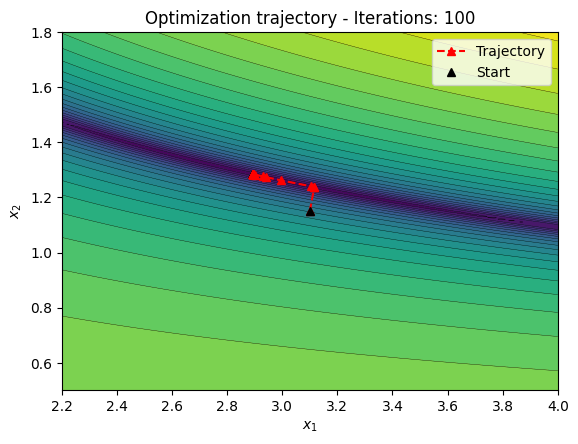

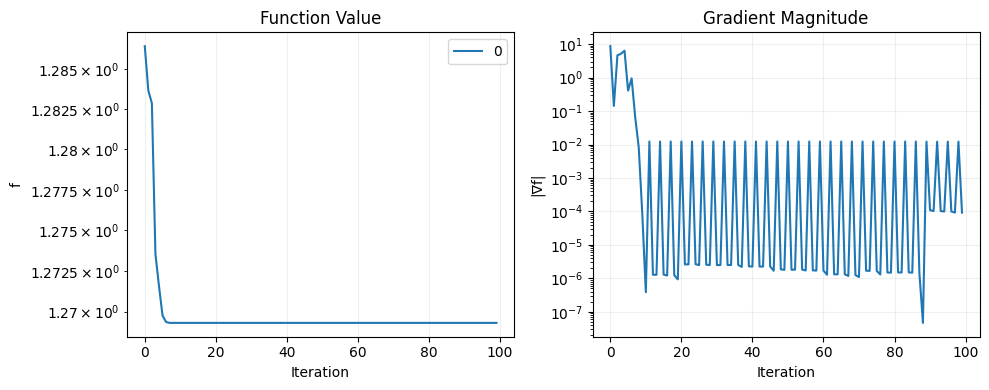

In [6]:
prob.plotSolutionHistory(history, logscale=True)
plot_histories([history], '0.1,0.1', xlog=(False, False), ylog=(True, True))
print('Final solution:')
print('        l = ', history['x'][-1][0])
print('        d = ', history['x'][-1][1])

Text(0, 0.5, '$d$ [m]')

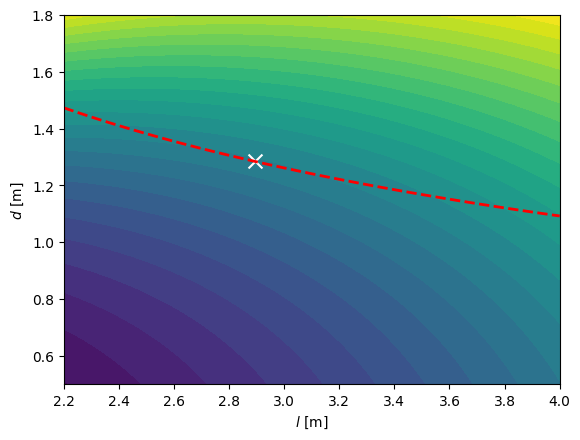

In [7]:
# verify the solution
L, D = np.meshgrid(np.linspace(lmin, lmax, 100), np.linspace(dmin, dmax, 100), indexing='ij')
MASS = np.zeros_like(L)
CONSTRAINT = np.zeros_like(L)

for i in range(L.shape[0]):
    for j in range(L.shape[1]):
        MASS[i, j] = computeDrag((L[i, j], D[i, j]), *args)
        CONSTRAINT[i, j] = 2.5 - computeVolume((L[i, j], D[i, j]), *args)

plt.contourf(L, D, MASS, levels=30)
plt.contour(L, D, CONSTRAINT, levels=[0], colors='r', linewidths=2, linestyles='--')
plt.scatter(history['x'][-1][0], history['x'][-1][1], c='w', marker='x', s=100)
plt.xlabel(r'$l$ [m]')
plt.ylabel(r'$d$ [m]')